In [136]:
import pandas as pd
import numpy as np
import re
import os
import glob
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import matplotlib.pyplot as plt
import graphviz
from sklearn import tree
import pydotplus
from collections import defaultdict
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error

In [45]:
#preparação dos dados do censo de 2010
#pode ignorar o warning que aparece
pathCenso2010 = "C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\Fundamentos de Sistemas Inteligentes\\ProjetoFinal"
os.chdir(pathCenso2010)
features_1 = pd.read_csv('Features1.csv',delimiter = ';',decimal = ',') #sheet 'Dados Gerais'
features_2 = pd.read_csv('Features2.csv',delimiter = ';',decimal = ',') #sheet 'Planilha 3'
features_3 = pd.read_csv('Features3.csv',delimiter = ';',decimal = '.') #sheet 'Faixa Etária'
mun_data = pd.read_csv('dtb_2010.csv', delimiter = ';',decimal = ',')

features_1['Município'] = features_1['Município'].astype(int)
mun_data['Município'] = (mun_data['Município']/10).astype(int) #corrige os erros no código dos municípios

a = pd.merge(features_1, mun_data, on = 'Município') #juntou o nome do município com os códigos do município
features_2 = features_2.iloc[:,60:94] #pega apenas o que é importante
features_3 = pd.concat([features_3.iloc[:,0:2],features_3.iloc[:,2:46].stack().str.replace(',','.').unstack(), features_3.iloc[:,46:49]],axis = 1)
features_3 = features_3.drop('Sigla da Unidade da Federação',axis=1)
dados_censo2010 = pd.concat([a, features_2 ,features_3], axis = 1) #junta tudo

dados_censo2010['Nome_Munic'] = dados_censo2010['Nome_Munic'].str.upper()
dados_censo2010['Nome_Munic'] = dados_censo2010['Nome_Munic'].map(lambda x: re.sub(r'[^\w\s]', '', x))
dados_censo2010['Nome_Munic'] = dados_censo2010['Nome_Munic'].str.replace(' ', '')


dados_censo2010 = dados_censo2010.drop(['UF',
 'Mesorregião',
 'Nome_Meso',
 'Microrregião',
 'Nome_Micro',
 'Código IBGE do Município',
 'Nome_UF'],axis=1)

dados_censo2010 = dados_censo2010.replace('\.+', np.nan, regex=True)
dados_censo2010 = dados_censo2010.replace(',','.',regex = True)
dados_censo2010.fillna(0,inplace = True)     



dados_censo2010 = pd.concat([dados_censo2010.iloc[:,0:30],dados_censo2010.iloc[:,48:dados_censo2010.shape[1]]],axis=1)
dados_censo2010 = dados_censo2010.iloc[:,0:45]

#list(dados_censo2010)

C:\Users\thiag\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (15,16,33,34,35,109,110,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [46]:
#determina a abstenção média por município no período de validade de um censo
pathElec2012_1t = 'C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\Fundamentos de Sistemas Inteligentes\\ProjetoFinal\\1Turno2012'
pathElec2012_2t = 'C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\Fundamentos de Sistemas Inteligentes\\ProjetoFinal\\2Turno2012'
pathElec2014_1t_gov = 'C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\Fundamentos de Sistemas Inteligentes\\ProjetoFinal\\1Turno14-Proc\\Governador'
pathElec2014_1t_pres = 'C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\Fundamentos de Sistemas Inteligentes\\ProjetoFinal\\1Turno14-Proc\\Presidente'
pathElec2014_2t_gov = 'C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\Fundamentos de Sistemas Inteligentes\\ProjetoFinal\\2Turno14-Proc\\Governador'
pathElec2014_2t_pres = 'C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\Fundamentos de Sistemas Inteligentes\\ProjetoFinal\\2Turno14-Proc\\Presidente'
pathElec2016_1t = 'C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\Fundamentos de Sistemas Inteligentes\\ProjetoFinal\\1Turno2016'
pathElec2016_2t = 'C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\Fundamentos de Sistemas Inteligentes\\ProjetoFinal\\2Turno2016'
pathElec2018_1t_gov = 'C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\Fundamentos de Sistemas Inteligentes\\ProjetoFinal\\1Turno2018\\Governador'
pathElec2018_1t_pres = 'C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\Fundamentos de Sistemas Inteligentes\\ProjetoFinal\\1Turno2018\\Presidente'
pathElec2018_2t_gov = 'C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\Fundamentos de Sistemas Inteligentes\\ProjetoFinal\\2Turno2018\\Governador'
pathElec2018_2t_pres = 'C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\Fundamentos de Sistemas Inteligentes\\ProjetoFinal\\2Turno2018\\Presidente'

paths = [pathElec2012_1t, pathElec2012_2t, pathElec2014_1t_gov, pathElec2014_1t_pres,
         pathElec2014_2t_gov, pathElec2014_2t_pres, pathElec2016_1t, pathElec2016_2t, pathElec2018_1t_gov, pathElec2018_1t_pres,
         pathElec2018_2t_gov, pathElec2018_2t_pres]

dataElecs = []
j=0
for path in paths:
    os.chdir(path)
    if (j<8):
        filenames = glob.glob("bweb_*.txt")
        dfs = [pd.read_table(filename,encoding = 'ISO-8859-1', delimiter = ',') for filename in filenames]
    else:
        filenames = glob.glob("bweb_*.csv")
        dfs = [pd.read_csv(filename,encoding = 'ISO-8859-1', delimiter = ',') for filename in filenames]
    i=0
    df_certo = []
    for df in dfs:
        UF_name = filenames[i]
        UF_name = UF_name[8:10]
        d = {'Sigla da Unidade da Federação':[UF_name]*(df.shape[0])}
        UF = pd.DataFrame(data = d)
        df_certo.append(pd.concat([df,UF], ignore_index=False, sort= False,axis=1))
        i = i+1
    data = pd.concat(df_certo, ignore_index=True,sort= False)
    #import pdb; pdb.set_trace()
    data.columns.values[0] = 'Nome_Munic'
    data['Nome_Munic'] = data['Nome_Munic'].astype('str')
    data['Nome_Munic'] = data['Nome_Munic'].str.upper()
   # import pdb; pdb.set_trace()
    data['Nome_Munic'] = data['Nome_Munic'].map(lambda x: re.sub(r'[^\w\s]', '', x))
    data['Nome_Munic'] = data['Nome_Munic'].str.replace(' ', '')
    nomeMunicEAbstencoes = pd.concat([data['Nome_Munic'],data['Sigla da Unidade da Federação'],data['Resultados_5']], ignore_index = True, axis = 1)
    nomeMunicEAbstencoes.columns = ['Nome_Munic','Sigla da Unidade da Federação', 'Abstencoes']
    dataElecs.append(nomeMunicEAbstencoes)  
    j = j+1
    
a = dataElecs[0]
for i in range(0,len(dataElecs)-1):    
    a = pd.merge(a,dataElecs[i+1], on = ['Nome_Munic', 'Sigla da Unidade da Federação'],how='left')
    i = i+1
    
a.mean(axis = 1)

absMediaPorMunic = pd.concat([a['Nome_Munic'], a['Sigla da Unidade da Federação'] , a.mean(axis=1)],axis=1)
absMediaPorMunic.columns.values[2] = 'AbsMedia'

In [113]:
#prepara os dados para a regressão

dados_aux = pd.merge(dados_censo2010,absMediaPorMunic,on = ['Sigla da Unidade da Federação', 'Nome_Munic'])
X = dados_aux.drop(['Município', 'Sigla da Unidade da Federação', 'Nome_Munic','AbsMedia'],axis=1)
X_aux = X
y = dados_aux['AbsMedia']

for i in range(0,X.shape[1]):
    if (X.iloc[:,i].dtype == 'O'):
        X.iloc[:,i] = pd.to_numeric(X.iloc[:,i], errors = 'coerce')

X = X.replace('\.+', np.nan, regex=True)
X = X.replace(',','.',regex = True)
X.fillna(0,inplace = True)        
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, shuffle = True)

In [51]:
#comparação entre os classificadores

regressors = [
    RandomForestRegressor(n_estimators = 500, max_depth = 100),
    KNeighborsRegressor(n_neighbors=15),
    linear_model.Lars(),
    MLPRegressor(hidden_layer_sizes = (50,), activation = 'logistic', alpha = 0.01),
    SVR(kernel = 'linear', C=1),
    SVR(kernel = 'rbf', C=1),
    
]

scores = []
#reg = RandomForestRegressor(n_estimators = 500, max_depth = 100)
#reg.fit(X_train,y_train)

for reg in regressors:
    reg.fit(X_train,y_train)
    rF = regressors[0]
    scores.append(reg.score(X_test,y_test))
scores

[0.5050415587246542,
 0.38211721626047646,
 -22453589152591.74,
 0.1060537396357214,
 -0.046973315174037245,
 -0.046973315174037245]

C:\Users\thiag\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


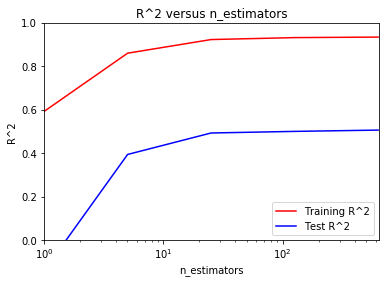

In [64]:
#determinação dos hiperparâmetros da Floresta Randômica

nEstimators = np.logspace(0, 2.8, 5)
R2_test = np.zeros(5)
R2_train = np.zeros(5)

j=0
for nEstimator in nEstimators:
    model =  RandomForestRegressor(n_estimators = int(round(nEstimator)), max_depth = 100)
    model.fit(X_train,y_train)
    np.put(R2_test,j,model.score(X_test,y_test))
    np.put(R2_train,j,model.score(X_train,y_train))
    j = j+1
    
plt.figure()
plt.semilogx(nEstimators,R2_train,'r',nEstimators,R2_test,'b')
plt.xlabel('n_estimators')
plt.ylabel('R^2')
plt.title('R^2 versus n_estimators')
plt.xlim([0, 640])
plt.ylim([0, 1])
plt.legend(['Training R^2','Test R^2'])


C:\Users\thiag\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


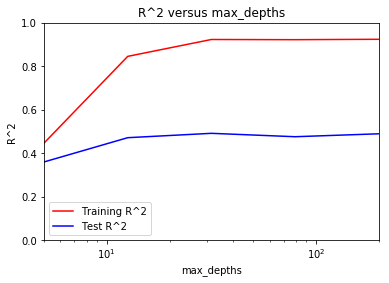

In [68]:
#determinação dos hiperparâmetros da Floresta Randômica

max_depths = np.logspace(0.7, 2.3, 5)
R2_test = np.zeros(5)
R2_train = np.zeros(5)

j=0
for max_depth in max_depths:
    model =  RandomForestRegressor(n_estimators = 30, max_depth = max_depth)
    model.fit(X_train,y_train)
    np.put(R2_test,j,model.score(X_test,y_test))
    np.put(R2_train,j,model.score(X_train,y_train))
    j = j+1
    
plt.figure()
plt.semilogx(max_depths,R2_train,'r',max_depths,R2_test,'b')
plt.xlabel('max_depths')
plt.ylabel('R^2')
plt.title('R^2 versus max_depths')
plt.xlim([0, 200])
plt.ylim([0, 1])
plt.legend(['Training R^2','Test R^2'])

In [130]:
model = RandomForestRegressor(n_estimators=30,max_depth=30)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

0.47839074873535314

In [137]:
R2 = r2_score(y_test, y_pred)
EVS = explained_variance_score(y_test, y_pred)
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
MedAE = median_absolute_error(y_test,y_pred)
print(R2,EVS,MAE,MSE,MedAE)

0.47839074873535314 0.4784624007418362 0.013266958461454308 0.00029731393203758714 0.01035350012613652


In [125]:
os.chdir('C:\\Users\\thiag\\Desktop\\Thiago\\UnB\\Fundamentos de Sistemas Inteligentes\\ProjetoFinal')
model = RandomForestRegressor(n_estimators=30,max_depth=30)

# Train
model.fit(X_train, y_train)
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_aux.columns,
                rounded = True, proportion = False, max_depth = 5,
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')

In [114]:
finalModel = RandomForestRegressor(n_estimators = 30, max_depth = 30)
finalModel.fit(X_train,y_train)
score = finalModel.score(X_test,y_test)
y_pred = finalModel.predict(X_test)
d = {'Abstencao Predita': y_pred}
y_pred_df = pd.DataFrame(data = d)
comparacao = pd.concat([dados_aux['Nome_Munic'], dados_aux['Sigla da Unidade da Federação'],dados_aux['AbsMedia'],y_pred_df],axis=1)
comparacao.iloc[0:100,:]

,Nome_Munic,Sigla da Unidade da Federação,AbsMedia,Abstencao Predita
0,ARIQUEMES,RO,0.205234,0.202961
1,CABIXI,RO,0.210574,0.207109
2,CACOAL,RO,0.210809,0.200207
3,CEREJEIRAS,RO,0.215107,0.172563
4,COLORADODOOESTE,RO,0.205572,0.202413
5,CORUMBIARA,RO,0.220528,0.199012
6,COSTAMARQUES,RO,0.205285,0.179921
7,GUAJARÁMIRIM,RO,0.223436,0.214699
8,JARU,RO,0.209471,0.209601
9,JIPARANÁ,RO,0.199902,0.178106


In [124]:
comparacao[comparacao['Nome_Munic'] == 'TERESINA']

,Nome_Munic,Sigla da Unidade da Federação,AbsMedia,Abstencao Predita
869,TERESINA,PI,0.139958,0.176268
